# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Quinn | Ledingham | Quinn Ledingham, 8-11-2024 | 4 | 25% |
| Member 2: | Gretchen  | Ge | Gretchen GE, 7-11-2024 | 4 | 25% |
| Member 3: | Zarek  | Zhai | Zarek Zhai, 7-11-2024 | 4 | 25% |
| Member 4: | Muhammad Ayan | Khan | Muhammad Ayan Khan, 7-11-2024 | 4 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

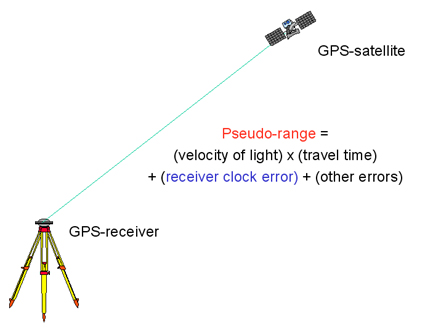

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [2]:
import os
import sys
if 'google.colab' in sys.modules:
  if not os.path.isdir('/content/drive/'):
    from google.colab import drive
    drive.mount('/content/drive/')

  %cd /content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3

In [3]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos = df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [4]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [5]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [6]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [7]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    predicted = euclidean_norm(r_pos, s_pos)
    r = pseudorange - (predicted + cdT)
    return np.sum(r ** 2)

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [8]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    grad = np.zeros(4)
    predicted = euclidean_norm(r_pos, s_pos)
    for i in range(len(s_pos)):
        # residual
        r = pseudorange[i] - (predicted[i] + cdT)
        # partial derivatives of cost function
        grad[0] += r * (r_pos[0] - s_pos[i][0]) / predicted[i]
        grad[1] += r * (r_pos[1] - s_pos[i][1]) / predicted[i]
        grad[2] += r * (r_pos[2] - s_pos[i][2]) / predicted[i]
        grad[3] += r
    return (-2/ len(s_pos)) * grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [9]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # update estimates
        # (1 mark)
        X_new = X - (learning_rate * grad)

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(new_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [10]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics
def print_metrics():
      print(f'Optimized parameters: {optimized_params}\n'
            f'Final position error: {optimized_params[:3]-GroundTruth}\n'
            f'Steps count: {steps_count}\n'
            f'Final cost value: { cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)}\n'
            f'Final gradient values: {arr_grad[-1]}')
print_metrics()

Converged !
Optimized parameters: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46487283e+00]
Final position error: [-3.06410407 -2.35577741  3.80056311]
Steps count: 3151
Final cost value: 6.197101203134901
Final gradient values: [ 4.69672781e-05  2.61704682e-04 -8.04332697e-04 -4.55997884e-04]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

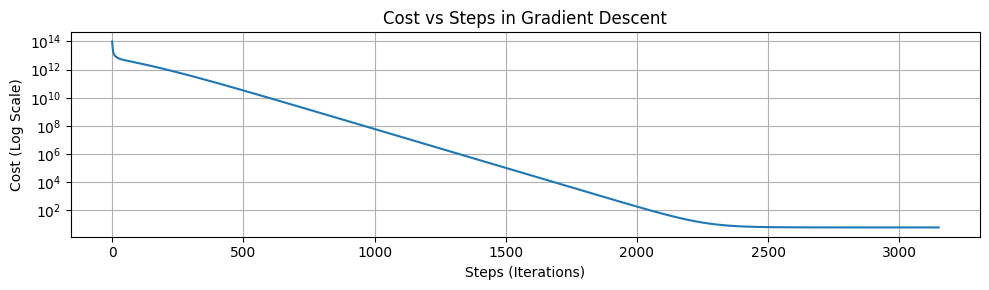

In [11]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.semilogy(arr_cost, label='Cost')
plt.xlabel('Steps (Iterations)')
plt.ylabel('Cost (Log Scale)')
plt.title('Cost vs Steps in Gradient Descent')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# Cost decreased steadily until around 2250 steps, then it leveled off.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

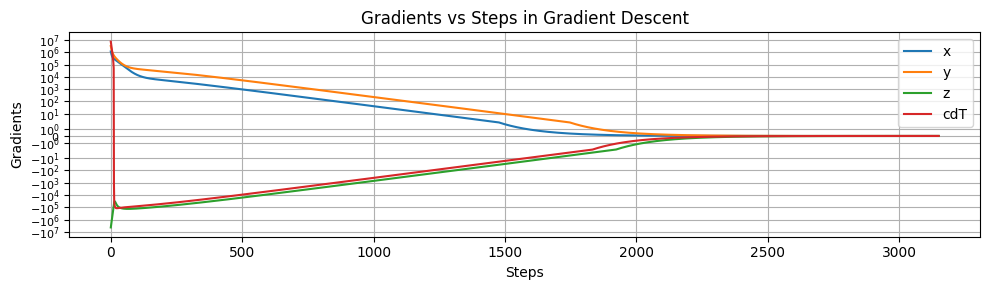

In [12]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.plot(list(range(steps_count)), arr_grad)
ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel('Steps')
ax.set_ylabel('Gradients')
plt.title('Gradients vs Steps in Gradient Descent')
plt.grid(True)
ax.legend(['x', 'y', 'z', 'cdT'])
fig.tight_layout()
plt.show()

# Comment on the pattern
# Both the positve and negative gradients went towards zero until around step 2100 when they reached
# very close to zero.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

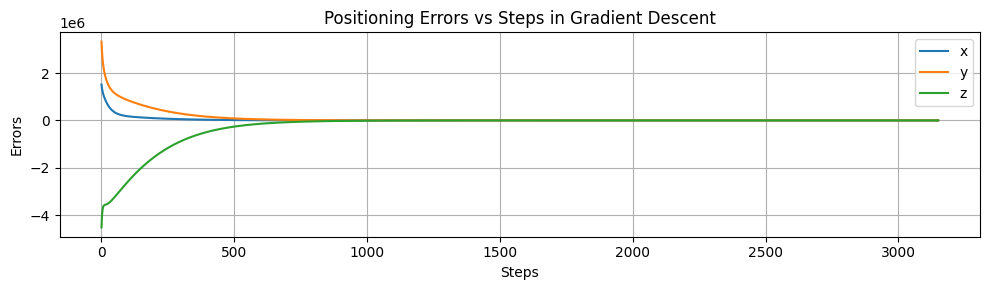

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(list(range(steps_count)), arr_err)
plt.title('Positioning Errors vs Steps in Gradient Descent')
ax.grid(True)
ax.set_xlabel('Steps')
ax.set_ylabel('Errors')
ax.legend(['x', 'y', 'z'])
fig.tight_layout()
plt.show()


# Comment on the pattern
# The errors move quickly towards zero until around the 700 step when
# they are very close to zero and it flattens out.
# X reaches close to zero the fastest while z takes longer.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [14]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=100000)

# print the metrics
print_metrics()

Converged !
Optimized parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44938808e+00]
Final position error: [-3.06250913 -2.34689044  3.77324973]
Steps count: 29782
Final cost value: 6.197817211057162
Final gradient values: [ 0.00014796  0.00082445 -0.00253389 -0.00143654]


In [15]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=1000000)

# print the metrics
print_metrics()

Converged !
Optimized parameters: [-1.63349244e+06 -3.65162950e+06  4.95248531e+06  6.40013170e+00]
Final position error: [-3.05743569 -2.31862133  3.6863669 ]
Steps count: 279686
Final cost value: 6.205048505340579
Final gradient values: [ 0.00046981  0.00261779 -0.00804556 -0.00456126]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)


Q1: It took more steps for the model to converge as the learning rate decreased, but the final position error got lower. The final cost is higher for lower learning rate because the grad is higher at the end since it converges when the cost stops getting lowered by greater than the tolerance amount.
Q2: Gradient Descent got sligtly lower position errors compared to the LSE position errors but it takes many more iterations because of how it slowly moves towards the target and unlike LSE the results depend on what the learning rate is.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [17]:
!pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\quinn\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# TO DO: display sizes of X and y (1 mark)
print(f"X: {X.shape}, y: {y.shape}")

X: (11055, 30), y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

result
 1        6157
-1        4898
Name: count, dtype: int64


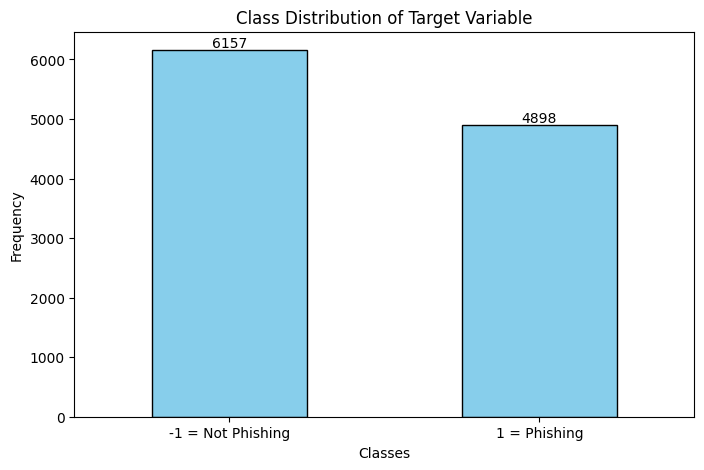

In [19]:
# TO DO: Check the class distribution of y (2 mark)
class_distribution = y.value_counts()
print(class_distribution)

plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution of Target Variable')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=["-1 = Not Phishing", "1 = Phishing"], rotation=0)  # Rotate x-axis labels for better visibility

# Display exact values for each bin in the histogram
for index, value in enumerate(class_distribution):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [20]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
train_size = 0.03
X_small, _, y_small, _ = train_test_split(X, y, train_size=train_size, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
xsa = X_small.shape
ysa = y_small.shape
print(f"x_small: {xsa}, y_small: {ysa}")

x_small: (331, 30), y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [21]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)
# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

random_state = 0
train_size = 0.7

results = pd.DataFrame(columns=['Data size', 'Training samples', 'Testing samples', 'Training accuracy', 'Testing accuracy', 'Log loss'])

def evaluate_model(X, y, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train.values.ravel())

    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    y_pred_prob = model.predict_proba(X_test)
    loss = log_loss(y_test, y_pred_prob)

    results.loc[model_name] = [X.shape[0], X_train.shape[0], X_test.shape[0], train_accuracy, test_accuracy, loss]

evaluate_model(X, y, 'Full Dataset (X, y)')

X_two_columns = X.iloc[:, :2]
y_two_columns = y.iloc[:, :2]
evaluate_model(X_two_columns, y_two_columns, 'First Two Columns (X, y)')

evaluate_model(X_small, y_small, 'Smaller Dataset (X_small, y_small)')

print(results)

                                    Data size  Training samples  \
Full Dataset (X, y)                   11055.0            7738.0   
First Two Columns (X, y)              11055.0            7738.0   
Smaller Dataset (X_small, y_small)      331.0             231.0   

                                    Testing samples  Training accuracy  \
Full Dataset (X, y)                          3317.0           0.932282   
First Two Columns (X, y)                     3317.0           0.562807   
Smaller Dataset (X_small, y_small)            100.0           0.943723   

                                    Testing accuracy  Log loss  
Full Dataset (X, y)                         0.922822  0.190326  
First Two Columns (X, y)                    0.556828  0.683573  
Smaller Dataset (X_small, y_small)          0.910000  0.200366  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [22]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
from sklearn.metrics import confusion_matrix, classification_report
random_state = 0
train_size = 0.7
# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
model = LogisticRegression(max_iter=2000, random_state=random_state)
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)
print(f"dim of predicted output: {y_pred.shape}")

dim of predicted output: (3317,)


Confusion Matrix:
[[1341  157]
 [  99 1720]]


Text(113.9222222222222, 0.5, 'true value')

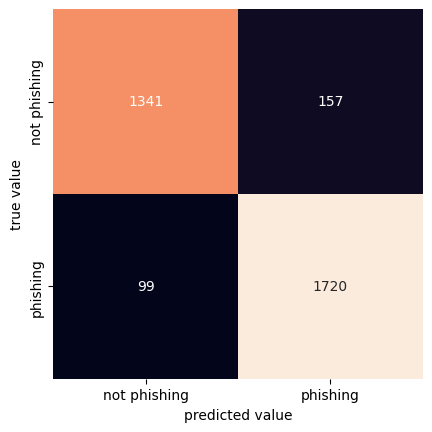

In [23]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [24]:
# TO DO: Print classification report (2 marks)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

-------
1. Yes, the dataset is somewhat imbalanced, with approximately 6157 samples of one class and 4898 of the other. This imbalance can potentially affect model performance, as an imbalanced dataset may lead the model to favor the majority class, resulting in lower precision or recall for the minority class. The impact is minimal in this case.
-------
2. Full Dataset (X, y): The training accuracy is 93.2%, and the testing accuracy is 92.3%. Since training and testing accuracies are similar and high, there is no sign of overfitting or underfitting. The model is well-fit to the data.
First Two Columns (X, y): The training accuracy is 56.3%, and the testing accuracy is 55.7%. Both accuracies are low, suggesting underfitting, likely due to the limited feature information, as only two features are used. This indicates that the model does not have enough data to learn the patterns effectively.
Smaller Dataset (X_small, y_small): The training accuracy is 94.4%, and the testing accuracy is 91.0%. The high training accuracy and slight drop in testing accuracy suggest mild overfitting, likely due to the limited data. With a smaller dataset, the model may learn the training data more precisely but struggle to generalize as well to unseen data.
-------
3. As the amount of data decreases, the model's training accuracy increases slightly, but the testing accuracy tends to drop. For instance:
- With the full dataset, the training accuracy is 93.2%, and the testing accuracy is 92.3%.
- With the smaller dataset (3%), the training accuracy increases to 94.4%, but the testing accuracy decreases to 91.0%. This suggests that a smaller dataset may lead to overfitting, as the model learns patterns specific to the training data, reducing its ability to generalize.
------
4. A false positive represents an instance where a non-phishing email is incorrectly classified as phishing & a false negative represents an instance where a phishing email is incorrectly classified as non-phishing.
In this case, a false negative is worse because it implies that a phishing email was missed, potentially allowing a user to fall victim to a phishing attack.
------
5. Given that false negatives are worse, we would want to maximize recall to reduce the chance of missing phishing emails.
- We can adjust the decision threshold of the classifier to be lower, so it classifies more cases as phishing.
- Use class weighting to emphasize the phishing class more in the model training.
- Use other methods that will minimize false negatives like ensemble methods or use a custom scorer like GridSearchCV that will prioritize recall.
------
6. The log loss values indicate the model's uncertainty in its predictions, with lower values representing better-calibrated predictions.
- X, y: The log loss is 0.19, which is the lowest among the three cases. This suggests that the model is confident and well-calibrated when using the full feature set and data.
- X_two_columns, y_two_columns: The log loss is 0.68, much higher than the other cases. The limited feature set likely causes this high log loss, as the model does not have enough information to make confident predictions.
- X_small, y_small: The log loss is 0.20, slightly higher than the full dataset but much lower than the two-column dataset. The smaller amount of data results in slightly less confidence in predictions due to limited training information, causing a small increase in log loss.


